## Interpolation Scheme for Montreal WD Models

**Input**: 
- Montreal DA/DB cooling sequences for WD masses 0.2 - 1.3 Msun (solar metallicity models)
- Cummings+18 IFMR
- MS lifetimes fit parameters

**Method**: 
- 1d cubic spline interpolation for the refinement of mass and age resolution 
- Calculate WD progenitor masses Mini using IFMR
- Find total age of WD by calculating MS lifetime of the progenitor for a range of metallicities
- Select mono-age data points to construct isochrones

**Output**: WD isochrones for the model age-metallicity grid

In [ ]:
import os
import numpy as np
from astropy.table import Table
from scipy.interpolate import interp1d, PchipInterpolator

import matplotlib as mpl
import matplotlib.pyplot as plt

from jjmodel.funcs import log_luminosity
from helpers import IFMRHandler, MSAgeHandler

### 1. Data exploration 

#### Montreal WD models 

We have Montreal white dwarf (WD) models in the form of cooling sequences for masses 0.2 - 1.3 Msun with a step of 0.1 Msun. 

#### Data Properties

Each cooling sequence is calculated on a **fixed temperature grid** spanning from ca. 1000 K to 150000 K (max Teff depends on WD mass, 60-70 points per cooling sequence). 

This data cannot be directly transformed into WD isochrones because:

- Mass resolution is too low (there will be max 9 points per curve)

- Ages that follow from Teff 

    - Form a grid with the resolution that is too low with respect to the grid used in our modelling (0.05 Gyr)

    - Do not correspond to the same age grid for the different masses. This, points of an "isochrone" constructed from this data will correspond to the different age bins, and isochrones won't be  smooth (illustrated below).

Let's load the Montreal cooling sequences and plot them on the CMD and Kiel diagram. 

In [ ]:

def read_wdcs(masses,models=['DA','DB'],data_dir='./wdcs'):
    '''Simple function for reading Montreal tables'''

    cooling_sq = {key:[] for key in models}

    for model in models:
        dir_model = os.path.join(data_dir, model, 'Table_Mass')
        for mass in masses:
            filename = os.path.join(dir_model, 'Table_Mass_' + str(mass) + '_' + model + '.txt')
            data = np.loadtxt(filename).T
            cooling_sq[model].append(data)

    return cooling_sq


def plot_wdcs(cooling_sq,col_idx,cmap=mpl.colormaps['managua_r'],dir_out='./'):
    '''Basic visualization of the WD cooling sequences: CMD and Kiel diagrams'''

    models = list(cooling_sq.keys())
    n_masses = len(cooling_sq[models[0]])

    # CMD
    # ----------------------------------------

    fig, ax = plt.subplots(1, 2, figsize=(12,4.5), sharey=True)

    ax[0].set_ylabel(r'$\mathrm{M_G}$')
    ax[0].arrow(0.6,7.0,0,2, head_width=0.04, head_length=0.5, fc='grey', ec='grey')
    ax[0].text(0.65,9.8, r'$\mathrm{WD \ mass}$', color='grey', rotation=90)

    for i, model in enumerate(models):
        ax[i].set_title(model)
        ax[i].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$')
        for j in range(n_masses):
            age = cooling_sq[model][j][col_idx['age']]/1e9  # in Gyr
            gaia_mag = cooling_sq[model][j][col_idx['G']]
            gaia_color = gaia_mag - cooling_sq[model][j][col_idx['G_RP']]
            cax = ax[i].scatter(gaia_color, gaia_mag, c=age, 
                                marker='o', s=5, cmap=cmap, vmin=0, vmax=14)
            ax[i].set_ylim(23,4)

    fig.subplots_adjust(right=0.88,wspace=0.1)
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label(r'$\mathrm{age_{\, WD}, \ Gyr}$')
    fig.savefig(os.path.join(dir_out,'wdcs_cmd.png'))


    # Kiel diagram 
    # --------------------------------------
    fig, ax = plt.subplots(1, 2, figsize=(12,4.5), sharey=True)

    ax[0].set_ylabel(r'$\mathrm{log(g)}$')
    ax[0].arrow(0.6,5.5,0,0.5, head_width=0.06, head_length=0.15, fc='grey', ec='grey')
    ax[0].text(0.55,6.3, r'$\mathrm{WD \ mass}$', color='grey', rotation=90)

    for i, model in enumerate(models):
        ax[i].set_title(model)
        ax[i].set_xlabel(r'$\mathrm{log(T_{eff}/10^3)}$')
        for j in range(n_masses):
            age = cooling_sq[model][j][col_idx['age']]/1e9  # in Gyr
            logg = cooling_sq[model][j][col_idx['logg']]
            logTeff = np.log10(cooling_sq[model][j][col_idx['Teff']]/1e3)
            cax = ax[i].scatter(logTeff, logg, c=age, 
                                marker='o', s=5, cmap=cmap, vmin=0, vmax=14)
            ax[i].set_ylim(10,5)
            ax[i].set_xlim(2.5,0)

    fig.subplots_adjust(right=0.88,wspace=0.1)
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label(r'$\mathrm{age_{\, WD}, \ Gyr}$')
    fig.savefig(os.path.join(dir_out,'wdcs_kiel.png'))


In [ ]:
# Info: I store CS under base_dir/DA/Table_Mass and base_dir/DB/Table_Mass

base_dir = './Montreal_WD_models' 
models=['DA','DB'] 
masses = np.round(np.arange(0.2,1.4,0.1),1) # available WD mass grid 

# Columns of interest and their positions 
# Here age is WD age, not total age!
col_idx = {'age':42,'Teff':0,'logg':1,'G':37,'G_BP':38,'G_RP':39}  

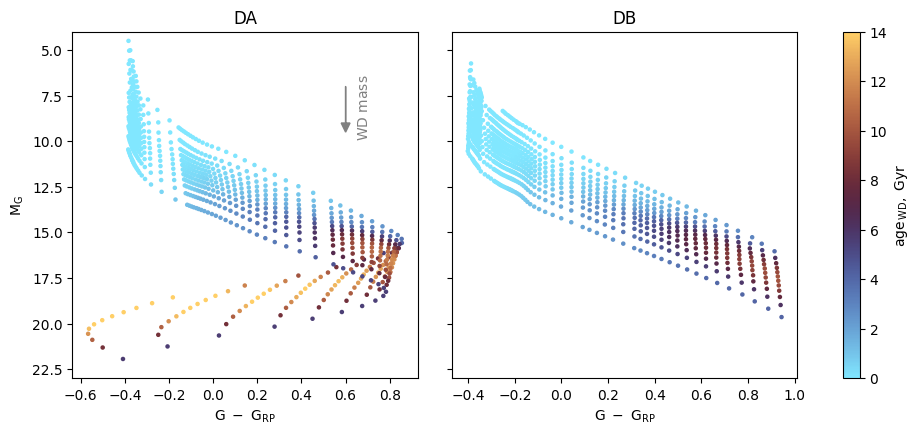

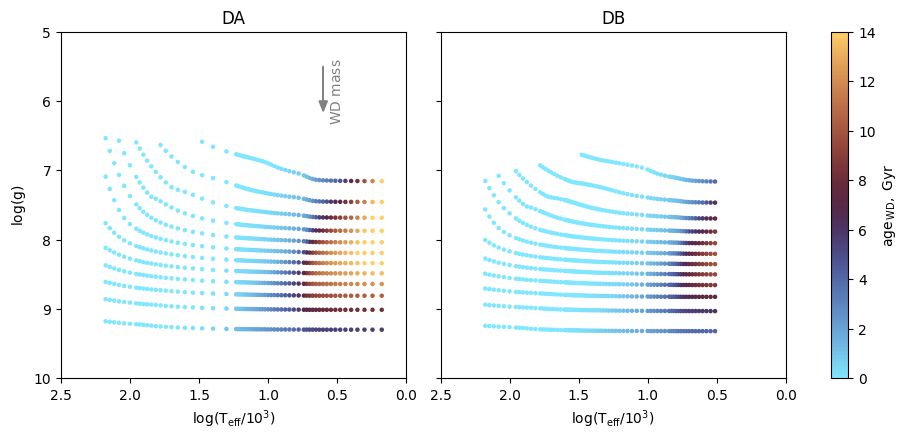

In [4]:
# Load the data and plot

cooling_sq = read_wdcs(masses,models=models,data_dir=base_dir)
plot_wdcs(cooling_sq,col_idx,dir_out=base_dir)

### 2. Cooling Sequence Interpolation

To obtain good-quality isochrones, Montreal cooling sequences need to be interpolated 

 - in WD mass (enough points per curve)

 - in WD age (single-age curve rather than points for an age range + enough ages)

#### 2.1 Interpolation in mass

To calculate all columns for additional masses, we need 

- Find min mass at which the WD starts cooling from a given Teff 
(low-mass WD start cooling from lower temperatures, so for a given mass we need to know which part of Teff grid is covered)

- Express each column as a function of mass on the available Teff grid and 

- Calculate their values on the 2d-grid {Teff, new_masses}


In [5]:
def get_min_mass_for_teff(cooling_sq,masses,teff_grid,dir_out='./'):
    '''
    Returns the lower WD mass limit for the CS starting-point Teff.
    Look at the plot for a better understanding. 
    '''

    models = list(cooling_sq.keys())

    min_mass_teff = {key:[] for key in models}
    max_teff_mass = {key:[] for key in models}

    for model in models:

        for i in range(len(masses)):
            teff_mass = cooling_sq[model][i][col_idx['Teff']]/1e3 # temperature grid for this mass
            max_teff_mass[model].append(max(teff_mass)) # get max value

        # Interpolate masses at the slope part (m < 0.6 Msun)
        # For m >= 0.6 Msun max Teff will be the max value of the full grid, 150000 K 
        
        lim_idx = np.where(max_teff_mass[model]==max(teff_grid[model]))[0][0] + 1
        spline = interp1d(max_teff_mass[model][:lim_idx],masses[:lim_idx])

        for t in teff_grid[model]:
            if t >= max_teff_mass[model][0]:
                min_mass_teff[model].append(np.round(spline(t),2))
            else:
                min_mass_teff[model].append(masses[0])

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_title(r'$\mathrm{Max(T_{eff})}$' + ' available for the cooling track at a given mass')
    ax.plot(masses,max_teff_mass['DA'],marker='o',markersize='5',label='DA')
    ax.plot(masses,max_teff_mass['DB'],marker='x',markersize='5',ls='--',label='DB')
    ax.set_xlabel(r'$\mathrm{mass_{\, WD}, \ M_\odot}$')
    ax.set_ylabel(r'$\mathrm{max(T_{eff}), \ 10^3 \, K}$')
    plt.legend(loc=4)
    fig.savefig(os.path.join(dir_out,'max_Teff_vs_mass.png'))

    return min_mass_teff

In [6]:

def interpolate_mass(cooling_sq,model,quantity,mass_grid,min_mass_teff,teff_grid,
                     log_scale=False,norm_factor=1,label='',ylim=(0,1),dir_out='./',
                     cmap = mpl.colormaps['viridis']):
    '''
    Extract iso-temperature sequences for a specified CS column. 
    For each sequence (Teff):
      - Perform spline fit of the quantity against the Wd mass
      - Calculate quantity over the new finer mass grid
    Returns a merged column for the cooling sequences for a fine mass resolution
    '''
    # Output lists
    mass_col, q_col = [], []

    # Construct the plot in parallel
    fig, ax = plt.subplots(1, 1, figsize=(8,6))

    # Define cmap
    cmap = mpl.colormaps['viridis']
    norm = mpl.colors.Normalize(vmin=teff_grid[0], vmax=teff_grid[-1])
    colors = cmap(norm(teff_grid))
    colors = cmap(np.linspace(0, 1, len(teff_grid)))

    # Go over all temperatures and collect column values for different masses 
    # (where this temperature is available)
    for i,t in enumerate(teff_grid):
        q_masses = []
        for j in range(len(masses)):
            teff_mass = np.round(cooling_sq[model][j][col_idx['Teff']]/1e3,2)
            if t in teff_mass:
                teff_idx = np.where(teff_mass == t)[0][0]
                q_mass = cooling_sq[model][j][col_idx[quantity]][teff_idx]/norm_factor
                if log_scale:
                    q_mass = np.log10(q_mass)
                q_masses.append(q_mass)
            else:
                q_masses.append(np.nan)
                
        q_masses = np.array(q_masses)
        mask = np.isfinite(q_masses)

        # Plot extracted iso-temperature sequences
        ax.scatter(masses, q_masses, s=15, marker='o',color=colors[i])

        if len(q_masses[mask]) < 2:
            # Check if interpolation possible
            print('Teff =', t, 'K: Interpolation is not possible, len(mask) =', 
                  len(q_masses[mask]))
            continue
        elif len(q_masses[mask]) == 2: 
            # If only two points - simple linear interpolation
            spline = interp1d(masses[mask], q_masses[mask])
        else:
            # Otherwise cubic spline with suppressed overshooting 
            # (doesn't distort data shape near the boundaries)
            spline = PchipInterpolator(masses[mask], q_masses[mask])
        
        # Find indices of min-max masses relevant for this Teff
        lim1 = np.where(mass_grid >= min_mass_teff[i])[0][0]
        lim2 = np.where(mass_grid <= masses[mask].max())[0][-1] + 1

        # Interpolate and add to the plot
        q_masses_interpolated = spline(mass_grid[lim1:lim2])
        mass_col.extend(mass_grid[lim1:lim2])
        q_col.extend(q_masses_interpolated)

        ax.plot(mass_grid[lim1:lim2], q_masses_interpolated, c='grey', lw=0.5)

    # Finish plotting
    ax.set_xlabel(r'$\mathrm{mass_{\, WD}, \ M_\odot}$')
    ax.set_ylabel(label)
    ax.set_ylim(ylim)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.colorbar(sm, ax=ax)
    cax.set_label(r'$\mathrm{T_{eff}, \ 10^3 \ K}$')
    fig.savefig(os.path.join(dir_out, model + '_interp_' + quantity + '.png'))
    
    return (mass_col, q_col), (fig, ax)


In [7]:

# Extract internal Teff grid in 10^3 K
# Index 6 corresponds to a mass with the full Teff grid (including the highest Teff)
teff_grid = {model:np.round(cooling_sq[model][6][col_idx['Teff']]/1e3,2) for model in models}

# Define fine-resolution WD mass grid
mass_step = 0.002 # Msun 
mass_grid = np.round(np.arange(0.2,1.3 + mass_step,mass_step),3)


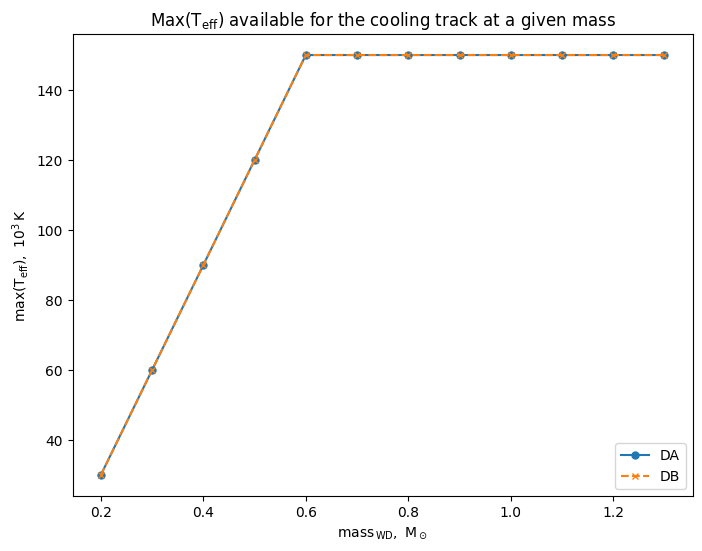

In [8]:

min_mass_teff = get_min_mass_for_teff(cooling_sq,masses,teff_grid,dir_out=base_dir)


In [ ]:
# Perform mass interpolation for all columns
# -------------------------------------------

params = {
    'age':{
        'log_scale':False,                          # Fit in log scale - True/False
        'norm_factor':1e9,                          # Normalize column prior to fitting
        'label':r'$\mathrm{age_{\, WD}, \ Gyr}$',   # Label for the plot
        'ylim':(-0.5, 16)                           # Y-axis range
        },
    'logg':{
        'log_scale':False,
        'norm_factor':1,
        'label':r'$\mathrm{\log{g}}$',
        'ylim':(5.2,9.5)
        },
    'Teff':{
        'log_scale':False,
        'norm_factor':1e3,
        'label':r'$\mathrm{Teff}$',
        'ylim':(0,150)
        },
    'G':{
        'log_scale':False,
        'norm_factor':1,
        'label':r'$\mathrm{G}$',
        'ylim':(23,3)
        },
    'G_BP':{
        'log_scale':False,
        'norm_factor':1,
        'label':r'$\mathrm{G_{BP}}$',
        'ylim':(23,3)
        },
    'G_RP':{
        'log_scale':False,
        'norm_factor':1,
        'label':r'$\mathrm{G_{RP}}$',
        'ylim':(23,3)
        }
}

# Apply to the Montreal data 
cooling_sq_m = {model:Table() for model in models}

for model in models:

    dir_out = os.path.join(base_dir,model)

    for quantity in params.keys():
        (mass, column), (fig, ax) =\
            interpolate_mass(cooling_sq,
                             model,
                             quantity,
                             mass_grid,
                             min_mass_teff[model],
                             teff_grid[model],
                             log_scale=params[quantity]['log_scale'],
                             norm_factor=params[quantity]['norm_factor'],
                             label=params[quantity]['label'],
                             ylim=params[quantity]['ylim'],
                             dir_out=dir_out
                            );
        plt.close()    
        cooling_sq_m[model][quantity] = column

    cooling_sq_m[model]['mass'] = mass
     

#### 2.2 Age Interpolation

In [ ]:
# Define a fine-resolution age grid consistent with the one used for MS isochrones
# Important! Isochrones are calculated with a larger step, 0.05 Gyr, 
# but interpolation should be done for this full-resolution grid. 
# Otherwise some ages won't be found at the final step of extracting isochrones 
# from the interpolated table. 

age_step = 0.025  # Gyr
age_max = 13.0    # Gyr
age_grid = np.round(np.arange(age_step, age_max + age_step, age_step),3)


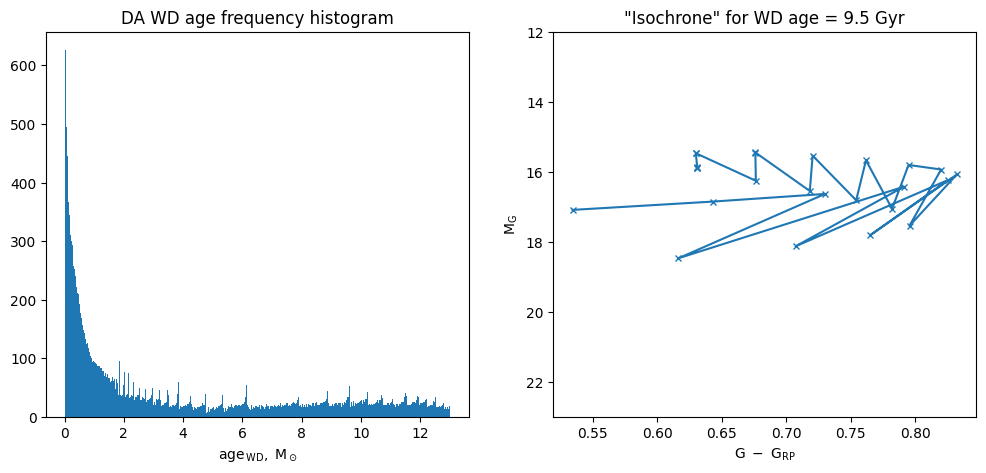

In [ ]:
# Plot for illustration - motivation for the additional age interpolation

model = 'DA'     # test model
age_value = 9.5  # Gyr, test WD age

# Select 'isochrone' based on the WD age (total age is not yet calculated)
# This is not the true isochrone, but it's only to show the quality

age_idx = np.argmin(np.abs(age_grid-age_value))
iso_idx = np.where((cooling_sq_m[model]['age'] > age_grid[age_idx] - age_step/2)&
                   (cooling_sq_m[model]['age'] < age_grid[age_idx] + age_step/2))[0]

fig, ax = plt.subplots(1,2,figsize=(12,5),sharey=False)
ax[0].hist(cooling_sq_m[model]['age'],bins=age_grid);
ax[0].set_xlabel(r'$\mathrm{age_{\, WD}, \ M_\odot}$')
ax[0].set_title(model + ' WD age frequency histogram')

ax[1].plot(cooling_sq_m[model]['G'][iso_idx] - cooling_sq_m[model]['G_RP'][iso_idx],
           cooling_sq_m[model]['G'][iso_idx],marker='x',markersize=5)
ax[1].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$')
ax[1].set_ylabel(r'$\mathrm{M_G}$')
ax[1].set_ylim(23,12)
ax[1].set_title('"Isochrone" for WD age = ' + str(age_value) + ' Gyr')

fig.savefig(os.path.join(base_dir,'age_interp_motivation.png'))


In [12]:

def interpolate_age(cooling_table,model,quantity,mass,age_grid,
                    label='',ylim=(0,1),plot=False,dir_out='./'):
    ''' 
    Similar to interpolate_mass, but for age grid and a fixed mass
    '''
    
    # Add a small noise to ages to avoid dublicated values 
    # Spline requires strictly ascending array, same values are not allowed
    age_col = np.array([val + 1e-4*np.abs(np.random.randn()) for val in cooling_table[model]['age']])
    
    # Select a cooling sequence subsequence from the big table
    mass_idx = np.where(cooling_table[model]['mass']==mass)[0]
    sort_idx = np.argsort(age_col[mass_idx])
    
    # Get age and the specified column 
    sorted_age = age_col[mass_idx][sort_idx]
    sorted_quantity = cooling_table[model][quantity][mass_idx][sort_idx]

    # Sanity check
    if len(sorted_quantity) < 2:
        print(model,' Interpolation for mass = ',mass,' Msun for ',quantity,
              ' is not possible. Skipping...')
        return None
    
    # Interpolate
    spline = PchipInterpolator(sorted_age,sorted_quantity)
                        
    # Make sure not to apply spline to ages larger than max age in the cooling sequence!
    max_age_idx = np.where(age_grid <= sorted_age[-1])[0][-1]

    age_grid_trunc = age_grid[:max_age_idx]
    q_interpolated = spline(age_grid_trunc)
    
    # Create plot if needed
    if plot:
        fig, ax = plt.subplots(1,1,figsize=(8,6))
        ax.scatter(sorted_age,sorted_quantity,marker='x',s=15,c='steelblue',
                   label='cool.seq. increased m-resolution')
        ax.plot(age_grid_trunc,q_interpolated,c='lawngreen',label='spline fit')
        ax.set_xlabel(r'$\mathrm{age_{\, WD}, \ Gyr}$')
        ax.set_ylabel(label)
        ax.text(0.08,0.9,r'$\mathrm{mass_{\, WD} \, = \,}$' + str(mass) + r'$\mathrm{\ M_\odot}$',
                transform=ax.transAxes);
        ax.set_ylim(ylim)
        plt.legend(loc=4)

        fig.savefig(os.path.join(dir_out,'age_interp_' + quantity + '_' + model + '.png'))

    return (age_grid_trunc, q_interpolated)


def interpolate_age_all_masses(cooling_table,cols_to_interpolate,mass_grid,age_grid):

    all_columns = cols_to_interpolate + ['age','mass']
    models = list(cooling_table.keys())
    
    # Output container
    cooling_sq_ma = {model:{col:[] for col in all_columns} for model in models}

    for model in models:
        print('\nInterpolating age for ' + model + ' models')
        for i, col in enumerate(cols_to_interpolate):
            print('\t' + col)
            for mass in mass_grid:
                age_grid_trunc, col_interp = interpolate_age(cooling_table,model,col,mass,age_grid)
                cooling_sq_ma[model][col].extend(col_interp)

                if i==0:
                    cooling_sq_ma[model]['age'].extend(age_grid_trunc)
                    cooling_sq_ma[model]['mass'].extend([mass for _ in np.arange(len(age_grid_trunc))])

    return cooling_sq_ma


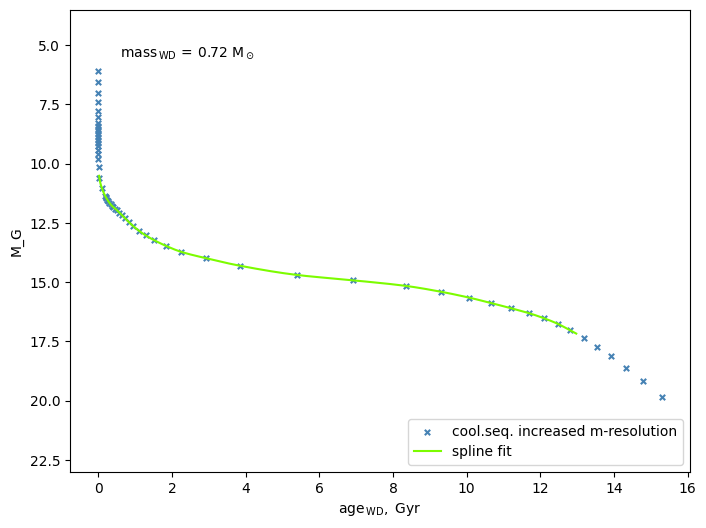

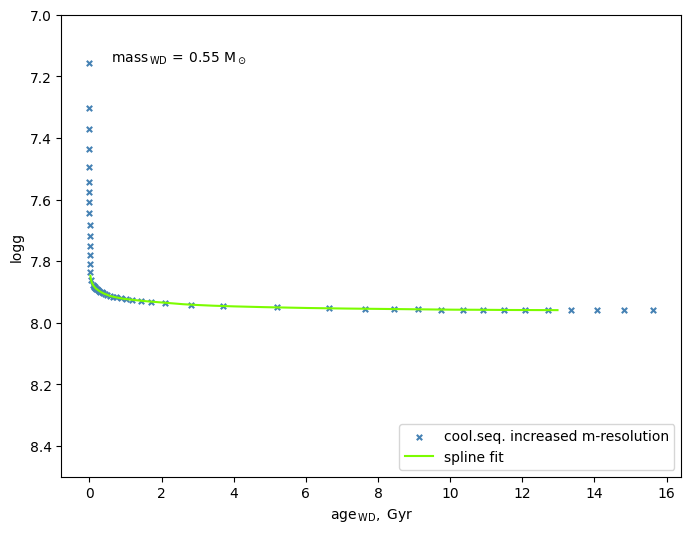

In [13]:
# Test age interpolation for a few examples

interpolate_age(cooling_sq_m,'DA','G',0.72,age_grid,
                label='M_G',ylim=(23,3.5),plot=True,dir_out=base_dir);

interpolate_age(cooling_sq_m,'DA','logg',0.55,age_grid,
                label='logg',ylim=(8.5,7),plot=True,dir_out=base_dir);


In [ ]:
# Apply age interpolation to all columns and all masses

cols_to_interpolate = ['Teff','logg','G','G_BP','G_RP']

cooling_sq_ma = interpolate_age_all_masses(cooling_sq_m,cols_to_interpolate,mass_grid,age_grid)



Interpolating age for DA models
	Teff
	logg
	G
	G_BP
	G_RP

Interpolating age for DB models
	Teff
	logg
	G
	G_BP
	G_RP


In [15]:

def get_progenitor_mass(cooling_table):
    '''Application of IFMR'''

    models = list(cooling_table.keys())

    ifmr = IFMRHandler()

    for model in models:
        # Here index 0 - progenitor mass, index 1 - its uncertainty
        cooling_table[model]['mini'] =\
            [ifmr.cummings_r(mass_wd)[0] for mass_wd in cooling_table[model]['mass']]
        
    return cooling_table
        

In [16]:
# Calculate progenitor mass based on the WD masses
cooling_sq_ma = get_progenitor_mass(cooling_sq_ma)

In [ ]:
# Read metallicity grid 
# old
#metgrid = np.loadtxt('../../jjmodel/jjmodel/input/isochrones/Metallicity_grid.txt').T[1]

# new
metgrid = np.loadtxt('../../isochrones/grids/metgrid_linFeH.txt').T[1]

FeH_grid = np.sort(metgrid)
FeH_grid = np.round(FeH_grid,2)

In [ ]:

def create_isochrones(cooling_table,FeH_grid,age_grid,age_step,iso_col_names,
                      param_file='./tau_ms_params.txt',dir_out='./'):

    '''Final step - extract single-age data points 
    from the full interpolated table = isochrone

    Apply to all metallicities. 
    '''

    tab = cooling_table.copy()
    models = list(tab.keys())

    agefit = MSAgeHandler(param_file=param_file)

    for model in models:
        print('\nCreating isochrones for ' + model + ' models')

        for met in FeH_grid:
            print('\t[Fe/H] = ',str(met))

            # Create metallicity folder 
            feh_dir = os.path.join(dir_out,model,'isochrones','iso_fe'+str(met))
            os.makedirs(feh_dir,exist_ok=True)

            # Derive MS lifetime and total age
            tab[model]['age_ms'] = agefit.get_age_ms(tab[model]['mini'],feh=met)
            tab[model]['age_tot'] = tab[model]['age'] + tab[model]['age_ms']
            tab[model]['age_tot'] = age_step*\
                                    (tab[model]['age_tot']//age_step +\
                                    np.round((tab[model]['age_tot']%age_step)/age_step,0)
                                    )
            
            for age_value in age_grid:
                
                age_value = np.round(age_value,3)
                # Select all stars with a given age
                iso_idx = np.where(np.round(cooling_table[model]['age_tot'],3)==age_value)[0]
                if len(iso_idx) > 0:
                    sort_idx = np.argsort(np.array(cooling_table[model]['mini'])[iso_idx])

                    # Construct isochrone
                    output = Table()
                    for col in tab[model].keys():
                        if col not in ['age_tot','age_ms']:
                            output[col] = np.array(tab[model][col])[iso_idx][sort_idx]

                            if col == 'Teff':
                                output[col] = np.log10(output[col])

                    # Add logL column
                    output['logL'] = log_luminosity(output['mass'],output['logg'],10**output['Teff'])
                    
                    order = ['mini','mass','logL','Teff','logg','age','G','G_BP','G_RP']
                    output = output[order]

                    filename = os.path.join(feh_dir, 'iso_age' + str(round(age_value,3)) + '.txt')
                    col_names = [iso_col_names[key] for key in output.keys() 
                                if key not in ['age_ms','age_tot']]

                    output.write(filename,names=col_names,format='ascii.fixed_width',delimiter=' ',
                                exclude_names=['age_ms','age_tot'],
                                formats={key:'%10.5f' for key in col_names},overwrite=True
                                )
                    
                    # Patch for header
                    with open(filename) as f:
                        lines = f.readlines()

                    with open(filename, "w") as f:
                        f.write("#" + lines[0][1:])   # header with hash
                        f.writelines(lines[1:])       # rest unchanged
                else:
                    #print('[Fe/H] = ' + str(met) + ': age ' + str(age_value) + ' Gyr is empty')
                    pass

    print('Done')
    

In [ ]:
iso_col_names = {'mini':'Mini','mass':'Mass','age':'age_WD',
                 'logg':'logg','Teff':'logTe','logL':'logL',
                 'G':'Gmag_EDR3','G_BP':'G_BPmag_EDR3','G_RP':'G_RPmag_EDR3'}

# Read parameters for MS lifetime fits
# old metgrid
#param_file = 'MS_lifetime_padova/analysis/fit_v1_Mbr1.2/tau_ms_params_v1_Mbr1.2.txt'
# new metgrid
param_file = 'MS_lifetime_padova_new_metgrid/analysis/fit_v1_Mbr1.18/tau_ms_params_v1_Mbr1.18.txt'

age_step = 0.05 # Gyr, age resolution of isochrones (x2 rougher than the actual model grid!)
create_isochrones(cooling_sq_ma,
                  FeH_grid,
                  age_grid,
                  age_step,
                  iso_col_names,
                  param_file=param_file,
                  dir_out=base_dir
                  );



Creating isochrones for DA models
	[Fe/H] =  -2.8
	[Fe/H] =  -2.7
	[Fe/H] =  -2.6
	[Fe/H] =  -2.5
	[Fe/H] =  -2.4
	[Fe/H] =  -2.3
	[Fe/H] =  -2.2
	[Fe/H] =  -2.1
	[Fe/H] =  -2.0
	[Fe/H] =  -1.9
	[Fe/H] =  -1.8
	[Fe/H] =  -1.7
	[Fe/H] =  -1.6
	[Fe/H] =  -1.5
	[Fe/H] =  -1.45
	[Fe/H] =  -1.4
	[Fe/H] =  -1.35
	[Fe/H] =  -1.3
	[Fe/H] =  -1.25
	[Fe/H] =  -1.2
	[Fe/H] =  -1.15
	[Fe/H] =  -1.1
	[Fe/H] =  -1.05
	[Fe/H] =  -1.0
	[Fe/H] =  -0.95
	[Fe/H] =  -0.9
	[Fe/H] =  -0.85
	[Fe/H] =  -0.8
	[Fe/H] =  -0.75
	[Fe/H] =  -0.7
	[Fe/H] =  -0.65
	[Fe/H] =  -0.6
	[Fe/H] =  -0.55
	[Fe/H] =  -0.5
	[Fe/H] =  -0.45
	[Fe/H] =  -0.4
	[Fe/H] =  -0.38
	[Fe/H] =  -0.36
	[Fe/H] =  -0.34
	[Fe/H] =  -0.32
	[Fe/H] =  -0.3
	[Fe/H] =  -0.28
	[Fe/H] =  -0.26
	[Fe/H] =  -0.24
	[Fe/H] =  -0.22
	[Fe/H] =  -0.2
	[Fe/H] =  -0.18
	[Fe/H] =  -0.16
	[Fe/H] =  -0.14
	[Fe/H] =  -0.12
	[Fe/H] =  -0.1
	[Fe/H] =  -0.08
	[Fe/H] =  -0.06
	[Fe/H] =  -0.04
	[Fe/H] =  -0.02
	[Fe/H] =  0.0
	[Fe/H] =  0.02
	[Fe/H] =  0.04
	[Fe/H] =  

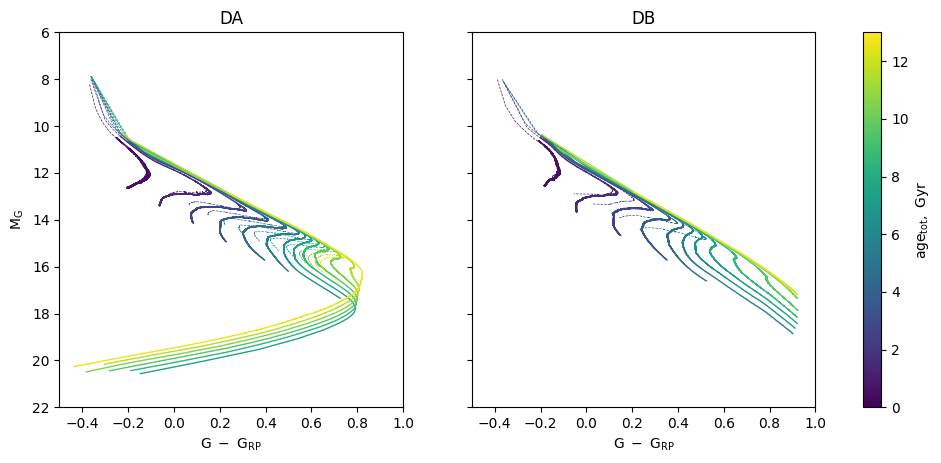

In [ ]:
# Plot old BaSTI and new Montreal isochrones for a set of test ages 
# -----------------------------------------------------------------

test_ages = np.arange(0.55,13.55,1)
test_feh = 0.02 # dex, test metallicity

mod1, mod2 = models, ['H','He']

fig, ax = plt.subplots(1,2,figsize=(10.5,5),sharey=True)

cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=0, vmax=13)
colors = cmap(norm(test_ages))
#colors = cmap(np.linspace(0, 1, len(test_ages)))

for i in range(len(models)):

    for j,age in enumerate(test_ages):

        # Read isochrones
        dir1 = os.path.join(base_dir,mod1[i],'interpolation_new_metgrid',
                            'isochrones','iso_fe'+str(test_feh))
        dir2 = '../../jjmodel/jjmodel/input/isochrones/BaSTI/WD/multiband/' +\
               mod2[i] + '/' + 'iso_fe' + str(test_feh)
        
        file1 = os.path.join(dir1,'iso_age' + str(round(age,3)) + '.txt')
        file2 = os.path.join(dir2,'iso_age' + str(round(age,3)) + '.txt')

        iso1 = np.loadtxt(file1).T
        G1 = iso1[6]
        G_RP1 = iso1[8]
        ax[i].plot(G1 - G_RP1, G1, c=colors[j], lw=1.0)

        try:
            iso2 = np.loadtxt(file2).T
            G2 = iso2[13]
            G_RP2 = iso2[15]
            ax[i].plot(G2 - G_RP2, G2, c=colors[j],ls='--',lw=0.5)
        except:
            pass

    ax[i].set_title(mod1[i])
    ax[i].set_ylim(22,6.0)
    ax[i].set_xlim(-0.5,1.0)
    ax[i].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$')
    if i == 0:
        ax[i].set_ylabel(r'$\mathrm{M_{G}}$')

fig.subplots_adjust(left=0.1, right=1.0, top=0.9, bottom=0.15)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for older matplotlib
cax = fig.colorbar(sm, ax=ax)
cax.set_label(r'$\mathrm{age_{tot}, \ Gyr}$')

fig.savefig(os.path.join(base_dir,'iso_comparison_new_metgrid.png'))
